## **Задание 5:**
Используя открытые датасеты для сегментации изображений (instance segmentation), реализовать сегментацию с помощью DBSCAN и UNet. Сравнить полученные результаты.

In [ ]:
# установим библиотеку с сегментационными моделями
!pip install --q -U git+https://github.com/qubvel/segmentation_models.pytorch
# и для аугментаций
!pip install --q -U git+https://github.com/albumentations-team/albumentations

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 19.6 MB/s eta 0:00:00


In [ ]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision.models.segmentation import fcn_resnet50
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.metrics import jaccard_score, f1_score

In [ ]:
class MyDataset(Dataset):
  def __init__(self, root_folder, augmentation=None, preprocessing=None):
    self.root_folder = root_folder
    self.augmentation = augmentation
    self.preprocessing = preprocessing

    # собираем пути до всех изображений и масок
    image_names = os.listdir(os.path.join(root_folder, 'images'))
    self.image_mask_pairs = [(os.path.join(root_folder, 'images', image_name),
                              os.path.join(root_folder, 'labels', image_name)) for image_name in image_names]

  def __len__(self):
    return len(self.image_mask_pairs)

  def __getitem__(self, idx):
    image_path, mask_path = self.image_mask_pairs[idx]

    image = cv2.imread(image_path)[..., :3][..., ::-1]
    mask = cv2.imread(mask_path, 0)[..., np.newaxis]

    if self.augmentation is not None:
      sample = self.augmentation(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask'] / 255.

    return image, mask

Ссылка на датасеет: https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation

In [ ]:
!unzip -qq /content/drive/MyDrive/3_сем/CV/dataset_5.zip

In [ ]:
dataset_path = '/content/dataset_5'

In [ ]:
# Вспомогательная функция для визуализации
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

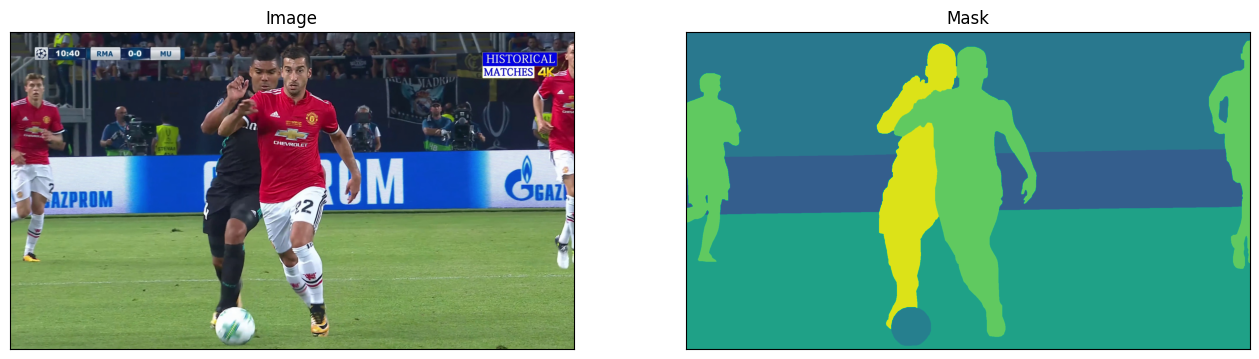

In [ ]:
# объявим датасет, чтобы посмотреть на данные
dataset = MyDataset(dataset_path)

# получим некий пример
image, mask = dataset[0]
visualize(
    image=image,
    mask=mask,
)

###DBSCAN

Загрузка изображения и предварительная обработка:

In [ ]:
image_path = '/content/dataset_5/images/11.jpg'
original_image = Image.open(image_path).resize((128, 128))
image_array = np.asarray(original_image, dtype=np.float32) / 255

Вычисление нормализованных индексов на основе RGB:

In [ ]:
red_channel, green_channel, blue_channel = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]
green_red_ratio = np.divide(green_channel - red_channel, green_channel + red_channel + 1e-6)
norm_index = (green_red_ratio + 1) / 2

Формирование набора данных для кластеризации:

In [ ]:
feature_matrix = np.stack([blue_channel.flatten(), norm_index.flatten()], axis=-1)

Выполнение кластеризации методом DBSCAN:

In [ ]:
dbscan_model = DBSCAN(eps=0.02, min_samples=12)
labels = dbscan_model.fit_predict(feature_matrix)
segmentation_map = labels.reshape(image_array.shape[:2]) + 1
segmentation_map = segmentation_map / segmentation_map.max()

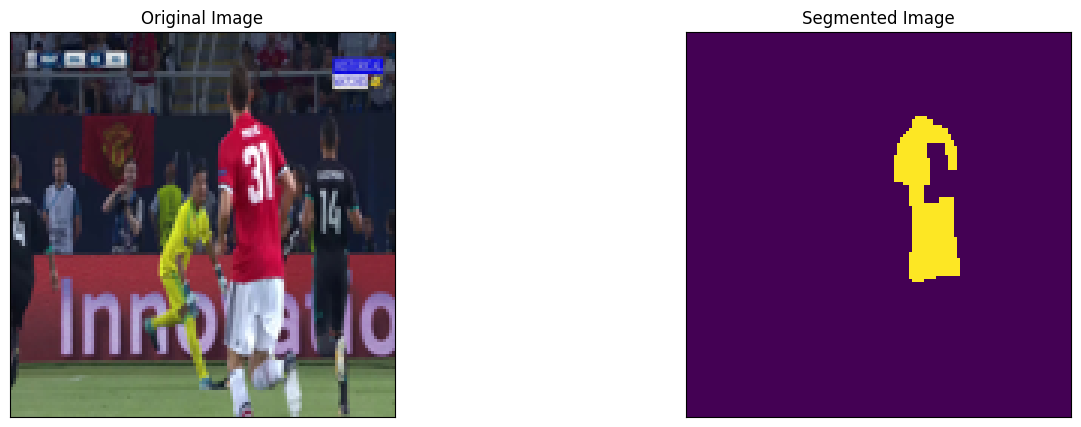

In [ ]:
segmentation_map = cv2.morphologyEx(segmentation_map, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
segmentation_map = cv2.morphologyEx(segmentation_map, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

visualize(Original_Image=image_array, Segmented_Image=segmentation_map)

In [ ]:
true_mask_path = '/content/dataset_5/labels/11.jpg'
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
true_mask_resized = cv2.resize(true_mask, segmentation_map.shape[::-1], interpolation=cv2.INTER_NEAREST)
true_binary_mask = (true_mask_resized > 127).astype(np.uint8)

predicted_binary_mask = (segmentation_map > 0).astype(np.uint8)

Вычисление метрик:

In [ ]:
true_flat = true_binary_mask.flatten()
predicted_flat = predicted_binary_mask.flatten()

iou_score = jaccard_score(true_flat, predicted_flat, average='binary')
dice_score = f1_score(true_flat, predicted_flat, average='binary')

print(f'IoU: {iou_score:.3f}, Dice Coefficient: {dice_score:.3f}')

IoU: 0.370, Dice Coefficient: 0.541


###UNet

In [ ]:
import albumentations as albu


def get_training_augmentation():
  """
    Аугментации для обучения. Данных очень мало, будем расширять таким способом.
  """
  train_transform = [
    albu.Resize(width=256, height=256),
    albu.HorizontalFlip(p=0.5),
    albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

    albu.GaussNoise(p=0.2),
    albu.Perspective(p=0.5),

    albu.OneOf(
      [
        albu.CLAHE(p=1),
        albu.RandomBrightnessContrast(p=1),
        albu.RandomGamma(p=1),
      ],
      p=0.9,
    ),

    albu.OneOf(
      [
        albu.Sharpen(p=1),
        albu.Blur(blur_limit=3, p=1),
        albu.MotionBlur(blur_limit=3, p=1),
      ],
      p=0.9,
    ),
    albu.RandomBrightnessContrast(p=0.9),
  ]
  return albu.Compose(train_transform)


def get_validation_augmentation():
  """
    Аугментации для тестирования
  """
  test_transform = [
    albu.Resize(width=256, height=256),
  ]
  return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
dataset = MyDataset(dataset_path, augmentation=get_training_augmentation())

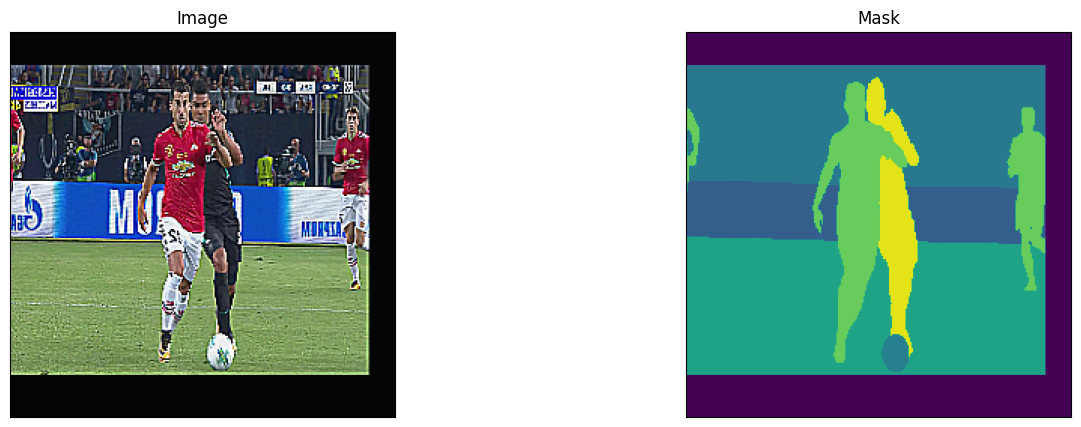

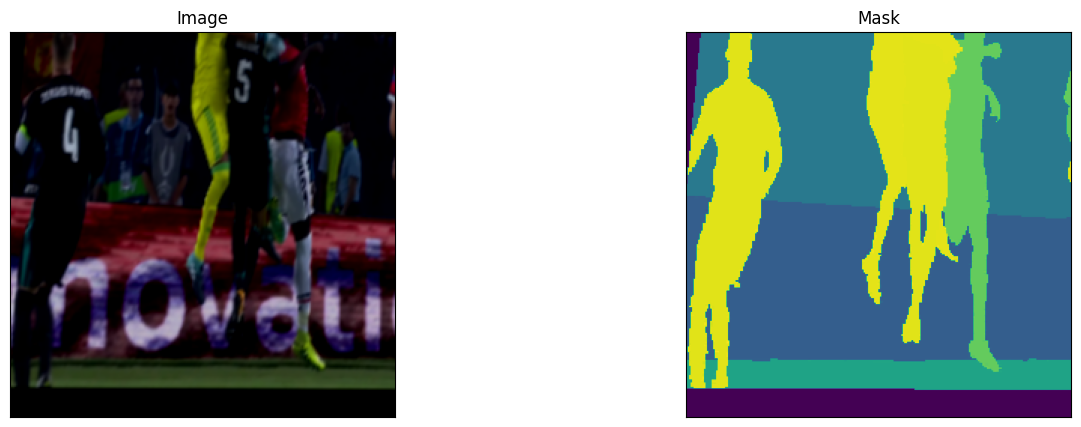

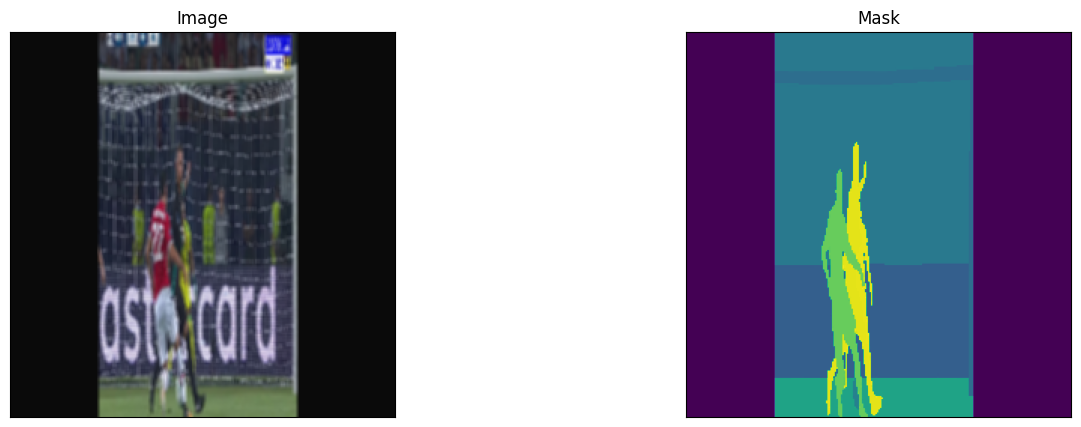

In [ ]:
# посмотрим на аугментации
image0, mask0 = dataset[0]
image1, mask1 = dataset[1]
image2, mask2 = dataset[2]
visualize(image=image0, mask=mask0)
visualize(image=image1, mask=mask1)
visualize(image=image2, mask=mask2)

In [ ]:
# объявим модель
import segmentation_models_pytorch as smp

# backbone
ENCODER_NAME = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
batch_size = 8
n_epochs = 25
device = 'cuda:0'

model = smp.Unet(
    encoder_name=ENCODER_NAME,       # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=ENCODER_WEIGHTS, # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                   # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                       # model output channels (number of classes in your dataset)
    activation='sigmoid'             # output activation function
)

# функция препроцессинга
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER_NAME, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 118MB/s]


In [ ]:
# определим датасеты и даталоадеры
dataset = MyDataset(dataset_path, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))


valid_size = int(len(dataset) * 0.2)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
import segmentation_models_pytorch.utils as smp_utils

# определим лоссы, метрики и оптимизатор
loss = smp_utils.losses.DiceLoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0002),])

In [ ]:
# передадим все данные во вспомогательные методы
train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

# обучение
for i in range(n_epochs):
    print('\nEpoch: {}'.format(i))
    # тренировочный цикл по пакетам данных
    train_logs = train_epoch.run(train_loader)
    # валидационный цикл по пакетам данных
    valid_logs = valid_epoch.run(valid_loader)

    # сохранение лучшей модели
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s, dice_loss - 0.557, iou_score - 0.3484]
Model saved!

Epoch: 1
valid: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s, dice_loss - 0.4828, iou_score - 0.4191]
Model saved!

Epoch: 2
valid: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s, dice_loss - 0.4507, iou_score - 0.4402]
Model saved!

Epoch: 3
valid: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s, dice_loss - 0.465, iou_score - 0.4131]

Epoch: 4
valid: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s, dice_loss - 0.4418, iou_score - 0.4322]

Epoch: 5
valid: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s, dice_loss - 0.4187, iou_score - 0.4566]
Model saved!

Epoch: 6
valid: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s, dice_loss - 0.4201, iou_score - 0.4514]

Epoch: 7
valid: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s, dice_loss - 0.4012, iou_score - 0.4626]
Model saved!

Epoch: 8
valid: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s, dice_loss - 0.4107, iou_score - 0.456]

Epoch: 9
v

In [ ]:
def calculate_metrics(pred_mask, true_mask):
    pred_bin = (pred_mask > 0.5).astype(np.uint8)
    true_bin = (true_mask > 0.5).astype(np.uint8)

    iou = jaccard_score(true_bin.flatten(), pred_bin.flatten(), average='binary')
    dice = f1_score(true_bin.flatten(), pred_bin.flatten(), average='binary')

    return iou, dice

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

iou_scores_list = []
dice_scores_list = []

with torch.no_grad():
  for image, mask in valid_loader:
    image, mask = image.to(device), mask.to(device)
    output = model(image)

    result_mask = np.uint8(255.*output.cpu().numpy()[0].transpose(1,2,0))[..., 0]
    mask = np.uint8(255.*mask.cpu().numpy()[0].transpose(1,2,0))[..., 0]

    image = image.cpu().numpy()[0].transpose(1,2,0)
    image[..., 0] = image[..., 0] * 0.229 + 0.485
    image[..., 1] = image[..., 1] * 0.224 + 0.456
    image[..., 2] = image[..., 2] * 0.225 + 0.406

    pred_mask_bin = (result_mask > 0.5).astype(np.uint8)
    true_mask_bin = (mask > 0.5).astype(np.uint8)

    iou, dice = calculate_metrics(pred_mask_bin, true_mask_bin)
    iou_scores_list.append(iou)
    dice_scores_list.append(dice)

    image = np.uint8(255*image)
    if i == len(valid_loader) - 1:
        break

In [ ]:
iou_score = np.mean(iou_scores_list)
dice_score = np.mean(dice_scores_list)

print(f'IoU: {iou_score:.3f}, Dice Coefficient: {dice_score:.3f}')

IoU: 0.468, Dice Coefficient: 0.602


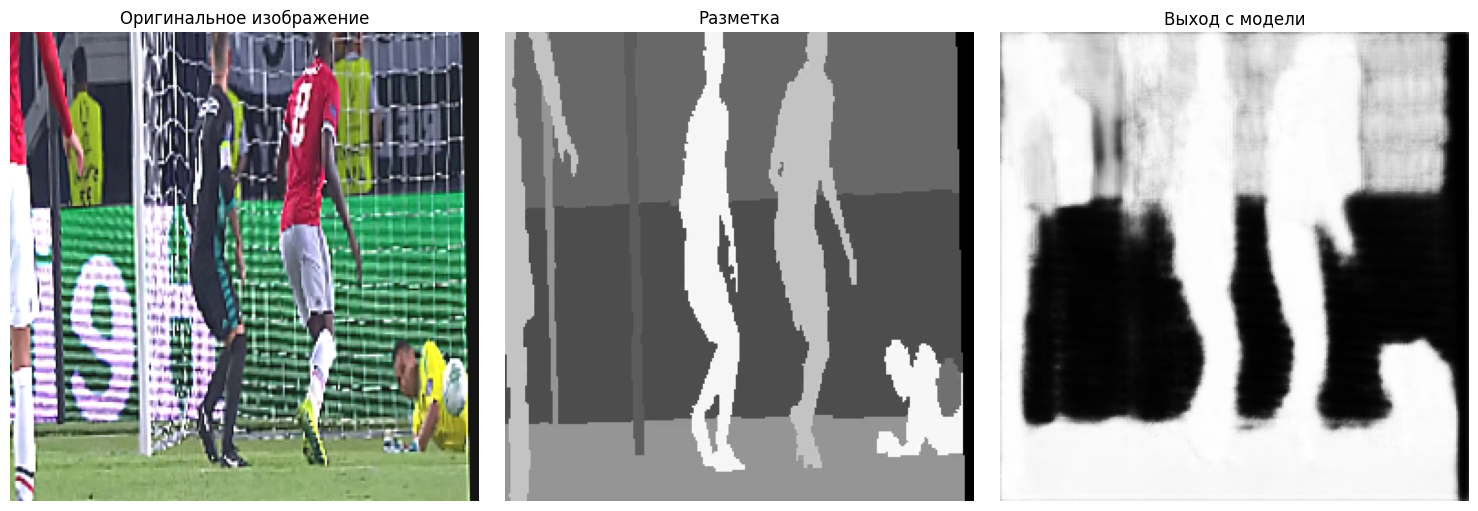

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Оригинальное изображение')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Разметка')
axes[1].axis('off')

axes[2].imshow(result_mask, cmap='gray')
axes[2].set_title('Выход с модели')
axes[2].axis('off')

plt.tight_layout()
plt.show()

**Вывод:** Результаты показали, что UNet *(IoU: 0.488, Dice Coefficient: 0.602)* продемонстрировал метрики немного лучше, чем DBSCAN *(IoU: 0.370, Dice Coefficient: 0.541)*. Скорее всего, это связано с тем, что UNet обладает большей гибкостью и способностью обучать сложные представления данных, а DBSCAN простая модель.